In [0]:
import time

import os
import glob
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

from PIL import Image
import skimage.io as ski
from skimage.transform import rescale, resize
import scipy.misc

from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

import parfit.parfit as pf


In [0]:
%matplotlib inline

In [0]:
def extract_class(path):
    dirname = re.search("/home/shahbaz/proj/size_normed_images/([a-zA-Z_]+)/.*", path)
    return dirname.group(1).replace("_cleaned_normed","").lower()

In [0]:
new_size = 64,64

### Read images

In [0]:
paths = [f for f in glob.glob('/home/shahbaz/proj/size_normed_images/**/*.jpg', recursive=True)
        if f.endswith('.jpg')]

train, test = train_test_split(paths, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.2)

train_labels = [extract_class(l) for l in train]
#train_images = [Image.open(img) for img in train]

test_labels = [extract_class(l) for l in test]
#test_images = [Image.open(img) for img in test]

valid_labels = [extract_class(l) for l in valid]

In [0]:
Xtrain = np.zeros( (len(train), new_size[0] * new_size[1] * 3) )
for index, item in enumerate(train):
    _img = Image.open(train[index])
    Xtrain[index] = np.asarray(_img.resize((new_size[0],new_size[1]))).flatten()
    _img.close()
    
Xtest  = np.zeros( (len(test) , new_size[0] * new_size[1] * 3) )
for index, item in enumerate(test):
    _img = Image.open(test[index])
    Xtest[index] = np.asarray(_img.resize((new_size[0],new_size[1]))).flatten()
    _img.close()

Xvalid  = np.zeros( (len(valid) , new_size[0] * new_size[1] * 3) )
for index, item in enumerate(valid):
    _img = Image.open(valid[index])
    Xvalid[index] = np.asarray(_img.resize((new_size[0],new_size[1]))).flatten()
    _img.close()

In [0]:
#?np.asarray(1,2,3).flatten()

In [0]:
Xtrain.shape
#len(train_labels)

(864, 12288)

In [0]:
confmat_labels = list(set(train_labels))
confmat_labels.sort()

### Build a model

In [0]:
"""
paramGrid = ParameterGrid({
    'min_samples_leaf': [1,3,5,10,15,25,50,100,125,150,175,200],
    'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7],
    'n_estimators': [60],
    'n_jobs': [-1],
    'random_state': [42]
})
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier, paramGrid, 
     Xtrain, np.array(train_labels), Xvalid, np.array(valid_labels), 
     metric=metrics.roc_auc_score, bestScore='max', scoreLabel='AUC')

print(best_model)
"""

"\nparamGrid = ParameterGrid({\n    'min_samples_leaf': [1,3,5,10,15,25,50,100,125,150,175,200],\n    'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7],\n    'n_estimators': [60],\n    'n_jobs': [-1],\n    'random_state': [42]\n})\nbest_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier, paramGrid, \n     Xtrain, np.array(train_labels), Xvalid, np.array(valid_labels), \n     metric=metrics.roc_auc_score, bestScore='max', scoreLabel='AUC')\n\nprint(best_model)\n"

### Random Forest Optimized Model

In [0]:
parameters = {
    'min_samples_leaf': [1,3,5,10,15,25,50,100,125,150,175,200],
    'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7],
    'n_estimators': [10, 30, 60, 90],
    'n_jobs': [-1],
    'random_state': [42]
}

random_forest_model = GridSearchCV(RandomForestClassifier(), parameters)
#random_forest_model = RandomForestClassifier()
%time random_forest_model.fit(Xtrain, np.array(train_labels))
best_model = random_forest_model


CPU times: user 4h 42min 33s, sys: 1min 6s, total: 4h 43min 40s
Wall time: 1h 34min 58s


In [0]:
predictedTrain = random_forest_model.predict(X=Xtrain)
predictedTest  = random_forest_model.predict(X=Xtest)

In [0]:
metrics.accuracy_score(np.array(test_labels), predictedTest)

0.25092250922509224

In [0]:
confmat_train = metrics.confusion_matrix( predictedTrain, np.array(train_labels) )

In [0]:
confmat_test = metrics.confusion_matrix( predictedTest, np.array(test_labels) )

In [0]:
pd.DataFrame(confmat_test)

,0,1,2,3,4,5,6,7
0,10,1,4,2,2,4,3,2
1,0,3,0,0,3,4,3,1
2,0,7,6,1,1,3,1,0
3,1,3,1,10,11,4,4,1
4,0,4,6,7,16,2,3,4
5,0,0,4,1,1,3,0,1
6,6,3,0,3,3,15,30,13
7,6,3,3,3,4,2,10,19


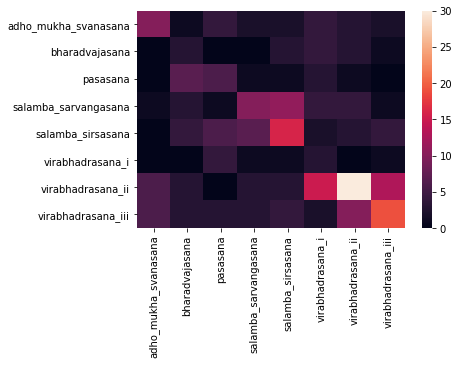

In [0]:
sn.heatmap(pd.DataFrame(confmat_test, confmat_labels, confmat_labels))

In [0]:
rf_probs = random_forest_model.predict_proba(Xtest)

In [0]:
metrics.log_loss(predictedTest, rf_probs)

1.2150895383113707

### SVM Optimized Model

In [0]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(estimator=SVC(probability=True), param_grid=parameters)
#svm_model = SVC()
%time svm_model.fit(Xtrain, np.array(train_labels))


CPU times: user 1h 23min 58s, sys: 2.7 s, total: 1h 24min 1s
Wall time: 1h 24min 1s


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['poly'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
svm_model.best_estimator_

AttributeError: 'SVC' object has no attribute 'best_estimator_'

In [0]:
best_model = svm_model

In [0]:
predictedTrain = svm_model.predict(X=Xtrain)
predictedTest  = svm_model.predict(X=Xtest)

In [0]:
metrics.accuracy_score(np.array(test_labels), predictedTest)

0.2029520295202952

In [0]:
confmat_train = metrics.confusion_matrix( predictedTrain, np.array(train_labels) )
#sn.heatmap(pd.DataFrame(confmat_train, train_labels, train_labels), annot=True)

In [0]:
confmat_test = metrics.confusion_matrix( predictedTest, np.array(test_labels) )

In [0]:
pd.DataFrame(confmat_test)

,0,1,2,3,4,5,6,7
0,8,2,2,2,2,4,8,7
1,1,5,1,3,4,3,2,2
2,2,10,11,2,6,2,1,1
3,2,4,3,7,8,6,4,3
4,3,0,2,6,11,2,6,3
5,0,0,1,3,1,6,9,2
6,1,3,1,3,2,11,19,1
7,6,0,3,1,7,3,5,22


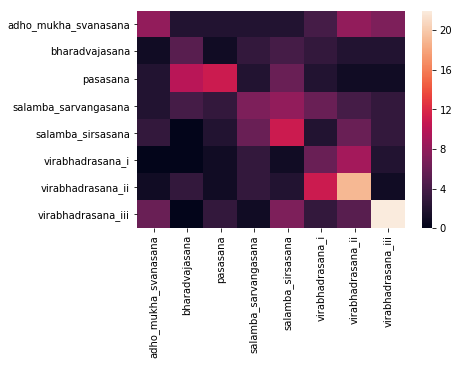

In [0]:
sn.heatmap(pd.DataFrame(confmat_test, confmat_labels, confmat_labels))

In [0]:
svm_probs = svm_model.predict_proba(Xtest)

In [0]:
metrics.log_loss(predictedTest, svm_probs)

1.3967890957468156

### Iterate through remaining models

In [0]:
def run_classifier(train, test, train_labels, test_labels, classifier_class):
    startt = time.time()
    classifier_class.fit( train, train_labels )

    probas = classifier_class.predict_proba(test)    
    results = classifier_class.predict( test)
    log_loss = metrics.log_loss(test_labels, probas)
    score = log_loss
    #score = classifier_class.score( test, test_labels )
    confmat = metrics.confusion_matrix(test_labels, results)
    confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis] #normalize
    duration = time.time() - startt
    return (type(classifier_class).__name__, score, duration, confmat)

In [0]:
# Taken from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LR(multi_class='ovr')]

In [0]:
#[(name, score, duration,confmat),(...),...]
classifier_rslt_all = [run_classifier(Xtrain, Xtest, train_labels, test_labels, classifier) for classifier in classifiers]

classifier_names = [e[0] for e in classifier_rslt_all]
confmats = [e[3] for e in classifier_rslt_all]


results = pd.DataFrame.from_records([ (e[0],e[1],e[2]) for e in classifier_rslt_all], columns=['Classifier', 'Score','Duration'])

/home/shahbaz/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [0]:
results

,Classifier,Score,Duration
0,KNeighborsClassifier,17.253131,10.487966
1,SVC,1.823961,114.069059
2,SVC,2.062476,126.143999
3,DecisionTreeClassifier,7.907396,3.305665
4,RandomForestClassifier,1.900734,0.036300
5,MLPClassifier,2.098540,4.194089
6,AdaBoostClassifier,2.049207,32.732486
7,GaussianNB,26.096382,0.310451
8,QuadraticDiscriminantAnalysis,28.421207,2.945149
9,LogisticRegression,7.125096,43.509126


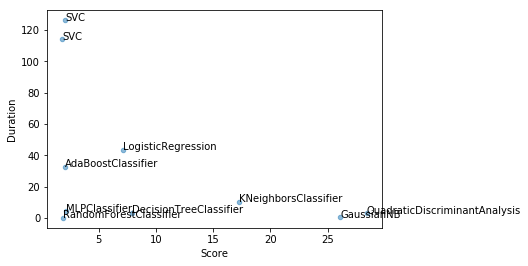

In [0]:
#results.plot.scatter(x='Score', y='Duration')
ax = results.plot.scatter(x='Score', y='Duration', alpha=0.5)
for i, txt in enumerate(results.Classifier):
    ax.annotate(txt, (results.Score.iat[i],results.Duration.iat[i]))

plt.show()

NameError: name 'labels' is not defined

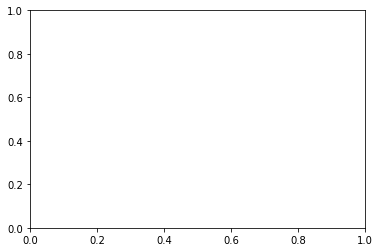

In [0]:
for confmat, classifier_name in zip(confmats, classifier_names):
    plt.figure()
    ax = plt.axes()
    sn.heatmap(pd.DataFrame(confmat, labels, labels), annot=True)
    ax.set_title(classifier_name)